# TNT Single-Mode: Flow Curve Fitting

## Learning Objectives
1. Understand the Tanaka-Edwards transient network theory for associative polymers
2. Fit TNT single-mode model to steady-state flow curve data
3. Extract network parameters: elastic modulus G, breakage time τ_b, solvent viscosity η_s
4. Predict normal stress differences from shear stress
5. Compare constant vs. Bell breakage variants
6. Perform Bayesian inference with NUTS for parameter uncertainty quantification

## Prerequisites
- Basic rheology concepts (shear stress, shear rate, viscosity)
- Familiarity with transient network models
- Understanding of Bayesian inference

## Runtime Estimate
- NLSQ fitting: ~2-5 seconds
- Bayesian inference (demo): ~30-60 seconds
- Total: ~2-3 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_flow_curve,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
    plot_weissenberg_number_effects,
    plot_variant_comparison,
    compute_tnt_normal_stress,
)

## 2. Theory

## Tanaka-Edwards Transient Network Theory

TNT models describe **associative polymer networks** with reversible crosslinks that continuously break and reform. Examples include:
- Telechelic polymers with hydrophobic end-groups
- Metal-organic coordination networks
- Hydrogen-bonded supramolecular assemblies

**Note**: TNT models describe associative polymer networks with reversible crosslinks. **Carbopol (yield-stress fluid) is not the natural target** — we use this data to demonstrate the workflow. For yield-stress fluids, see Fluidity or DMT models.

### Governing Equations

The conformation tensor **S** evolves according to:

$$
\frac{dS}{dt} = \mathbf{L} \cdot \mathbf{S} + \mathbf{S} \cdot \mathbf{L}^T + g_0 \mathbf{I} - \beta(\mathbf{S}) \cdot \mathbf{S}
$$

where:
- $\mathbf{L}$ is the velocity gradient tensor
- $g_0$ is the strand creation rate
- $\beta(\mathbf{S})$ is the breakage rate tensor

### Constant Breakage Variant

For **constant breakage**: $\beta = 1/\tau_b$

At steady state, the flow curve reduces to:

$$
\sigma(\dot{\gamma}) = G \tau_b \dot{\gamma} + \eta_s \dot{\gamma}
$$

This is identical to the **Upper Convected Maxwell (UCM)** model — **no shear thinning**.

### Bell Breakage Variant

For **stress-dependent Bell breakage**: $\beta = (1/\tau_b) \exp(\nu \tau / G)$

This introduces nonlinearity and shear thinning.

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Network stiffness | 1-1000 Pa |
| Breakage time | $\tau_b$ | Crosslink lifetime | 0.01-100 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |
| Bell parameter | $\nu$ | Stress sensitivity (Bell only) | 0.1-2 |

## 3. Load Data

In [2]:
# Load flow curve data (Carbopol gel)
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data shape: {len(gamma_dot)} points")
print(f"Shear rate range: {gamma_dot.min():.3e} - {gamma_dot.max():.3e} s⁻¹")
print(f"Stress range: {stress.min():.2f} - {stress.max():.2f} Pa")

Data shape: 21 points
Shear rate range: 1.000e-02 - 1.000e+02 s⁻¹
Stress range: 0.75 - 51.46 Pa


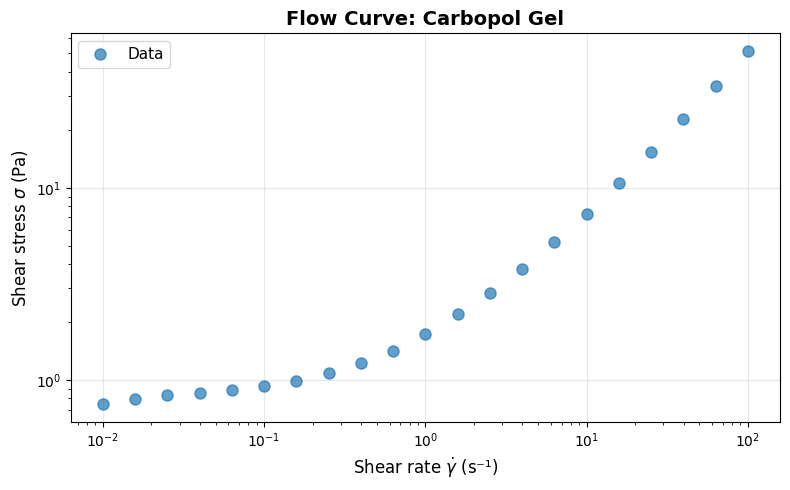

In [3]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, 'o', label='Data', markersize=8, alpha=0.7)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=12)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
ax.set_title('Flow Curve: Carbopol Gel', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. NLSQ Fitting

In [4]:
# Create model and fit
model = TNTSingleMode(breakage="constant")

start_time = time.time()
result = model.fit(gamma_dot, stress, test_mode="flow_curve", method="scipy")
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")


NLSQ fitting completed in 0.30 seconds

Fitted Parameters:
  G = 1.0021e+00
  tau_b = 7.3335e-01
  eta_s = 1.1624e-12


In [5]:
# Compute fit quality metrics
metrics = compute_fit_quality(stress, model.predict(gamma_dot, test_mode="flow_curve"))
r2 = metrics["R2"]
rmse = metrics["RMSE"]
mape = metrics.get("NRMSE", 0.0) * 100  # NRMSE as percentage
print(f"\nFit Quality:")
print(f"  R² = {r2:.6f}")
print(f"  RMSE = {rmse:.4e} Pa")
print(f"  MAPE = {mape:.2f}%")


Fit Quality:
  R² = 0.796552
  RMSE = 5.7898e+00 Pa
  MAPE = 11.42%


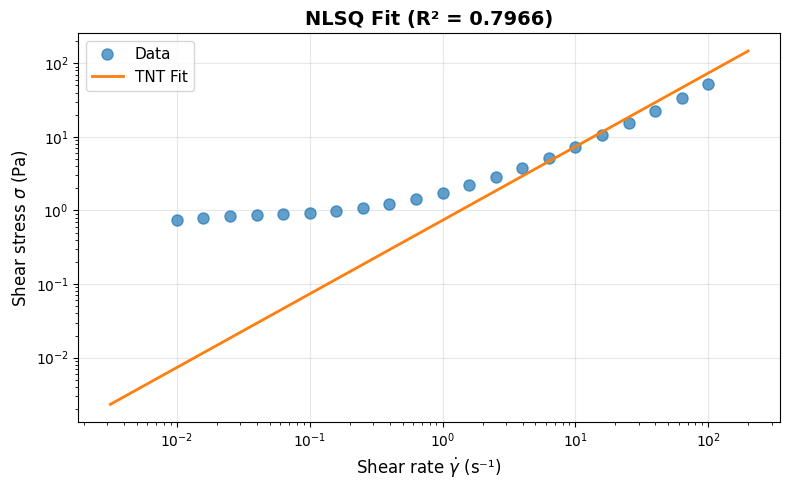

In [6]:
# Plot fit overlay
gamma_dot_fine = np.logspace(np.log10(gamma_dot.min())-0.5, np.log10(gamma_dot.max())+0.3, 200)
stress_pred = model.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, 'o', label='Data', markersize=8, alpha=0.7)
ax.loglog(gamma_dot_fine, stress_pred, '-', label='TNT Fit', linewidth=2)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=12)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
ax.set_title(f'NLSQ Fit (R² = {r2:.4f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

ERROR:rheojax.core.base:Fit failed with unexpected error
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 318, in fit
    self._fit(X, y, method=method, **kwargs)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/single_mode.py", line 495, in _fit
    result = nlsq_optimize(
        objective,
    ...<3 lines>...
        max_iter=kwargs.get("max_iter", 2000),
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 896, in nlsq_optimize
    scipy_result = scipy_least_squares(
        residual_fn,
    ...<6 lines>...
        method="trf",
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py", line 717, in inner
    return func(*args, **kwargs)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/scipy/optimize/_lsq/least_squares.py", line 946, in least_squares
    raise ValueError("Residuals

Bell variant comparison skipped: ValueError


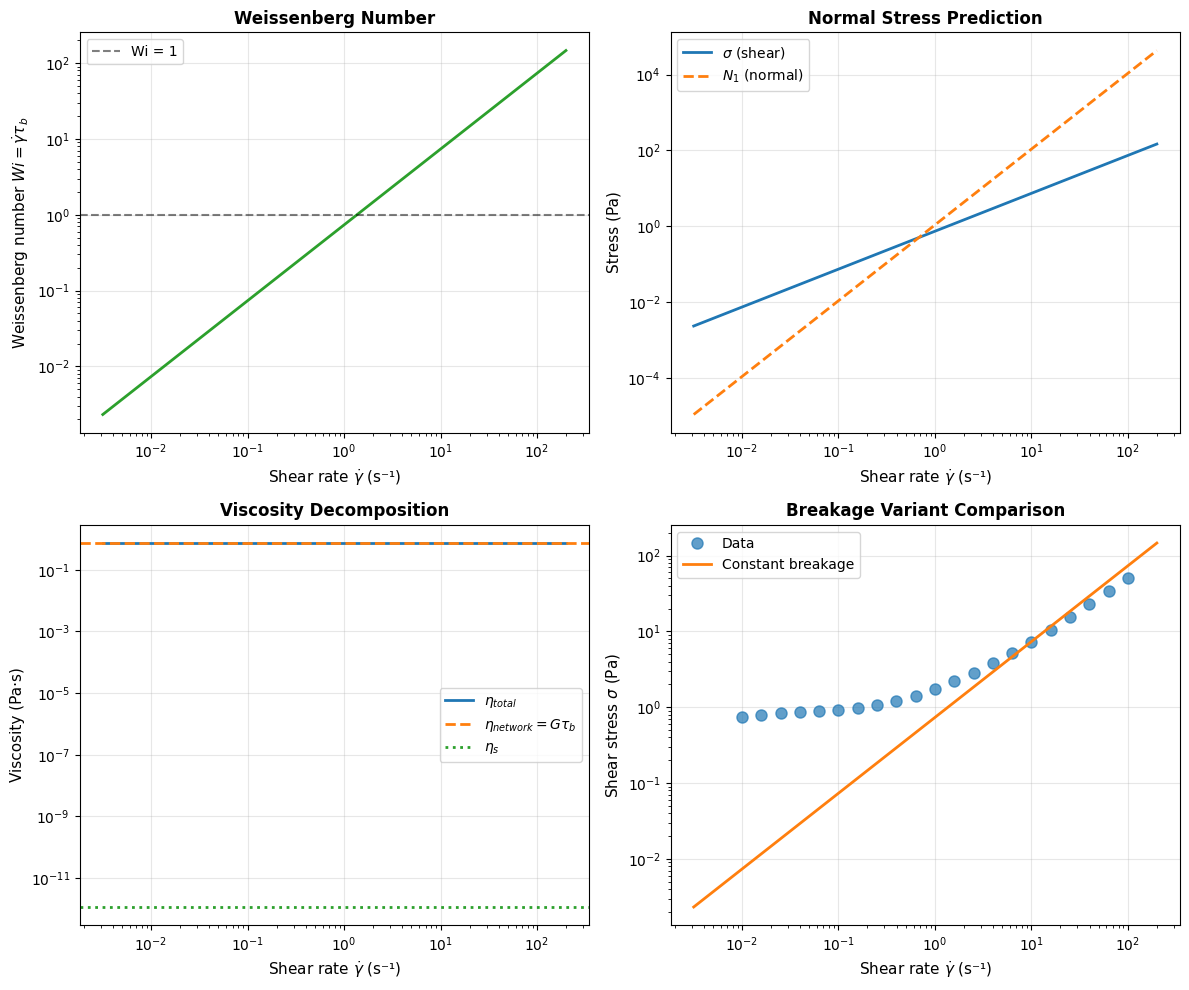


Physical Interpretation:
  Network modulus: G = 1.00 Pa
  Breakage time: τ_b = 0.7334 s
  Network viscosity: η_network = G·τ_b = 0.73 Pa·s
  Solvent viscosity: η_s = 1.1624e-12 Pa·s
  Viscosity ratio: η_network/η_s = 632234753403.1


In [7]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Weissenberg number analysis
ax = axes[0, 0]
Wi = gamma_dot_fine * tau_b
ax.loglog(gamma_dot_fine, Wi, '-', linewidth=2, color='C2')
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Wi = 1')
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=11)
ax.set_ylabel(r'Weissenberg number $Wi = \dot{\gamma}\tau_b$', fontsize=11)
ax.set_title('Weissenberg Number', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Normal stress prediction
ax = axes[0, 1]
N1 = compute_tnt_normal_stress(gamma_dot_fine, G, tau_b)
ax.loglog(gamma_dot_fine, stress_pred, '-', label=r'$\sigma$ (shear)', linewidth=2)
ax.loglog(gamma_dot_fine, N1, '--', label=r'$N_1$ (normal)', linewidth=2)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=11)
ax.set_ylabel('Stress (Pa)', fontsize=11)
ax.set_title('Normal Stress Prediction', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Viscosity decomposition
ax = axes[1, 0]
eta_total = stress_pred / gamma_dot_fine
eta_network = G * tau_b * np.ones_like(gamma_dot_fine)
ax.loglog(gamma_dot_fine, eta_total, '-', label=r'$\eta_{total}$', linewidth=2)
ax.axhline(y=G*tau_b, color='C1', linestyle='--', label=r'$\eta_{network} = G\tau_b$', linewidth=2)
ax.axhline(y=eta_s, color='C2', linestyle=':', label=r'$\eta_s$', linewidth=2)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=11)
ax.set_ylabel('Viscosity (Pa·s)', fontsize=11)
ax.set_title('Viscosity Decomposition', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. Variant comparison (constant vs. Bell)
ax = axes[1, 1]
ax.loglog(gamma_dot, stress, 'o', label='Data', markersize=8, alpha=0.7)
ax.loglog(gamma_dot_fine, stress_pred, '-', label='Constant breakage', linewidth=2)
try:
    model_bell = TNTSingleMode(breakage="bell")
    result_bell = model_bell.fit(gamma_dot, stress, test_mode="flow_curve", method="scipy")
    stress_bell = model_bell.predict(gamma_dot_fine, test_mode="flow_curve")
    ax.loglog(gamma_dot_fine, stress_bell, '--', label='Bell breakage', linewidth=2)
except Exception as e:
    print(f"Bell variant comparison skipped: {type(e).__name__}")
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=11)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Breakage Variant Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Breakage time: τ_b = {tau_b:.4f} s")
print(f"  Network viscosity: η_network = G·τ_b = {G*tau_b:.2f} Pa·s")
print(f"  Solvent viscosity: η_s = {eta_s:.4e} Pa·s")
print(f"  Viscosity ratio: η_network/η_s = {(G*tau_b)/eta_s:.1f}")

## 5. Bayesian Inference with NUTS

In [8]:
# Bayesian inference configuration
# Demo configuration (fast)
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

# Production configuration (uncomment for publication)
# NUM_WARMUP = 200
# NUM_SAMPLES = 400
# NUM_CHAINS = 1

print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")

start_time = time.time()
bayesian_result = model.fit_bayesian(
    gamma_dot, stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
bayes_time = time.time() - start_time

print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")

Running NUTS with 1 chain(s)...
Warmup: 200 samples, Sampling: 500 samples


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:33,  1.36it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 20/700 [00:00<00:21, 31.72it/s, 223 steps of size 2.34e-03. acc. prob=0.85]

warmup:   4%|▍         | 31/700 [00:00<00:14, 45.82it/s, 63 steps of size 6.18e-03. acc. prob=0.90] 

warmup:   8%|▊         | 58/700 [00:01<00:06, 92.48it/s, 15 steps of size 1.42e-02. acc. prob=0.94]

warmup:  16%|█▌        | 109/700 [00:01<00:03, 187.84it/s, 1023 steps of size 3.24e-04. acc. prob=0.94]

warmup:  20%|█▉        | 139/700 [00:01<00:02, 193.91it/s, 1023 steps of size 2.14e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [00:01<00:02, 205.52it/s, 1023 steps of size 3.13e-03. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [00:01<00:02, 211.11it/s, 1023 steps of size 3.04e-03. acc. prob=0.96]

sample:  32%|███▏      | 226/700 [00:01<00:01, 241.42it/s, 999 steps of size 3.46e-03. acc. prob=1.00] 

sample:  37%|███▋      | 257/700 [00:01<00:01, 256.63it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  41%|████      | 286/700 [00:01<00:01, 264.80it/s, 471 steps of size 3.46e-03. acc. prob=1.00] 

sample:  45%|████▌     | 315/700 [00:01<00:01, 256.22it/s, 463 steps of size 3.46e-03. acc. prob=1.00]

sample:  49%|████▉     | 342/700 [00:02<00:01, 250.39it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  53%|█████▎    | 368/700 [00:02<00:01, 239.07it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  56%|█████▌    | 393/700 [00:02<00:01, 240.43it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  60%|█████▉    | 418/700 [00:02<00:01, 222.74it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  63%|██████▎   | 441/700 [00:02<00:01, 217.29it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  66%|██████▋   | 464/700 [00:02<00:01, 219.19it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  70%|██████▉   | 487/700 [00:02<00:00, 220.43it/s, 415 steps of size 3.46e-03. acc. prob=1.00] 

sample:  73%|███████▎  | 510/700 [00:02<00:00, 198.41it/s, 1023 steps of size 3.46e-03. acc. prob=1.00]

sample:  77%|███████▋  | 537/700 [00:02<00:00, 214.75it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [00:03<00:00, 202.80it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [00:03<00:00, 220.36it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [00:03<00:00, 235.00it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [00:03<00:00, 254.36it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [00:03<00:00, 256.07it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:03<00:00, 256.19it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:03<00:00, 192.34it/s, 1023 steps of size 3.46e-03. acc. prob=0.99]


Bayesian inference completed in 6.7 seconds


In [9]:
# Convergence diagnostics
print_convergence_summary(bayesian_result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
          tau_b    1.0000       500      PASS
          eta_s    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

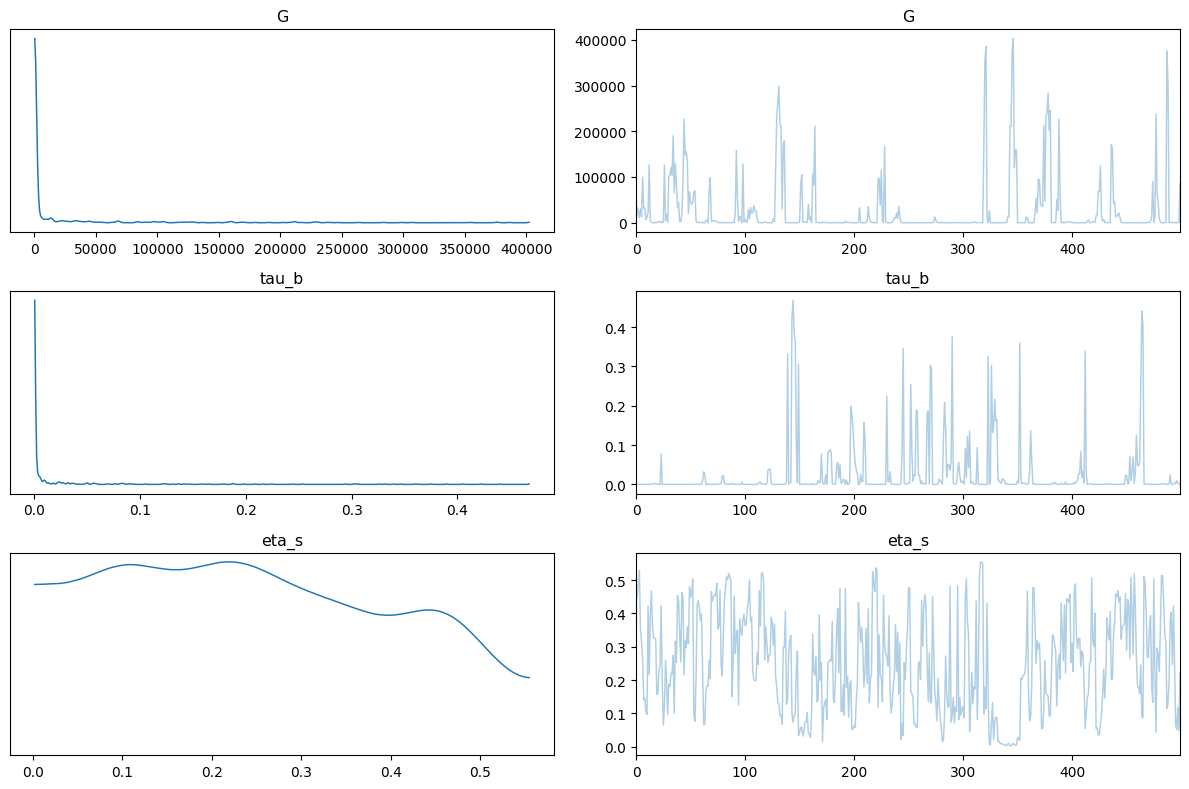

In [10]:
# ArviZ trace plots
idata = az.from_dict(posterior=bayesian_result.posterior_samples)
axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
plt.tight_layout()
plt.show()
plt.close('all')

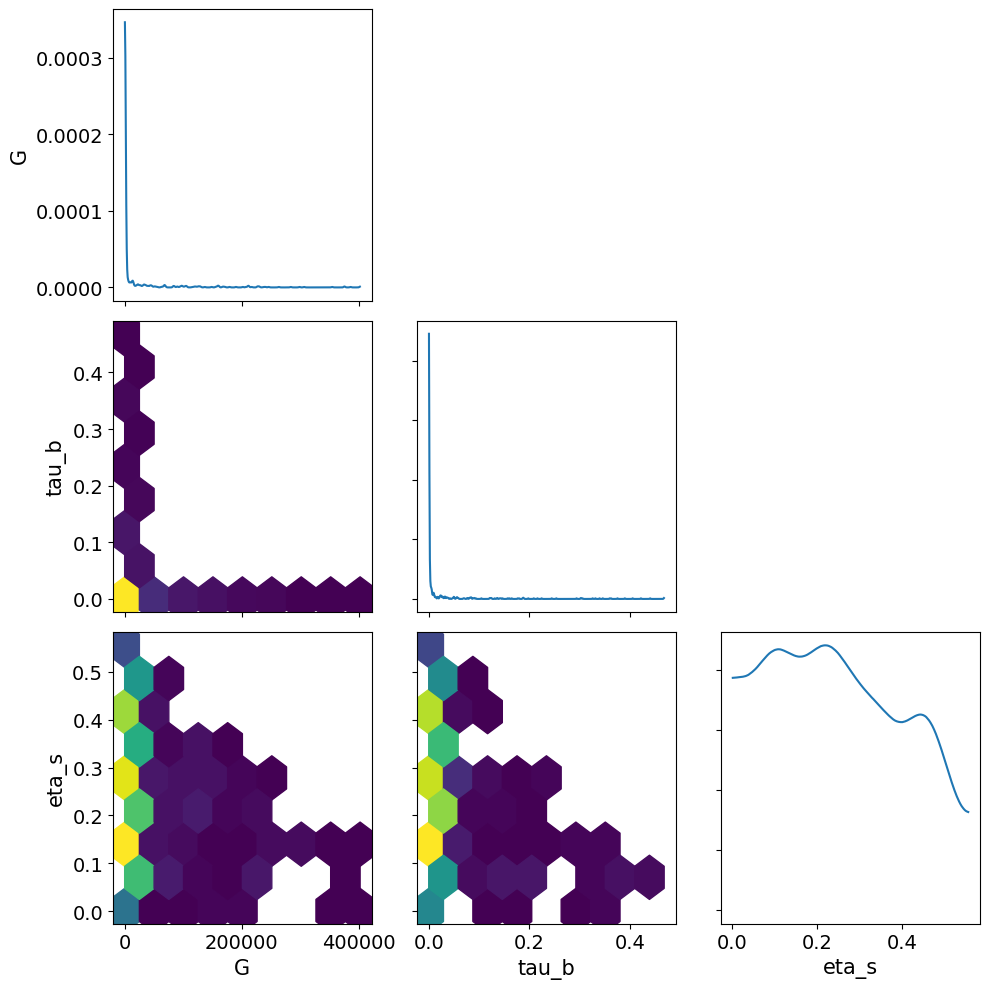

In [11]:
# ArviZ pair plot
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind='hexbin',
    marginals=True,
    figsize=(10, 10)
)
plt.tight_layout()
plt.show()
plt.close('all')

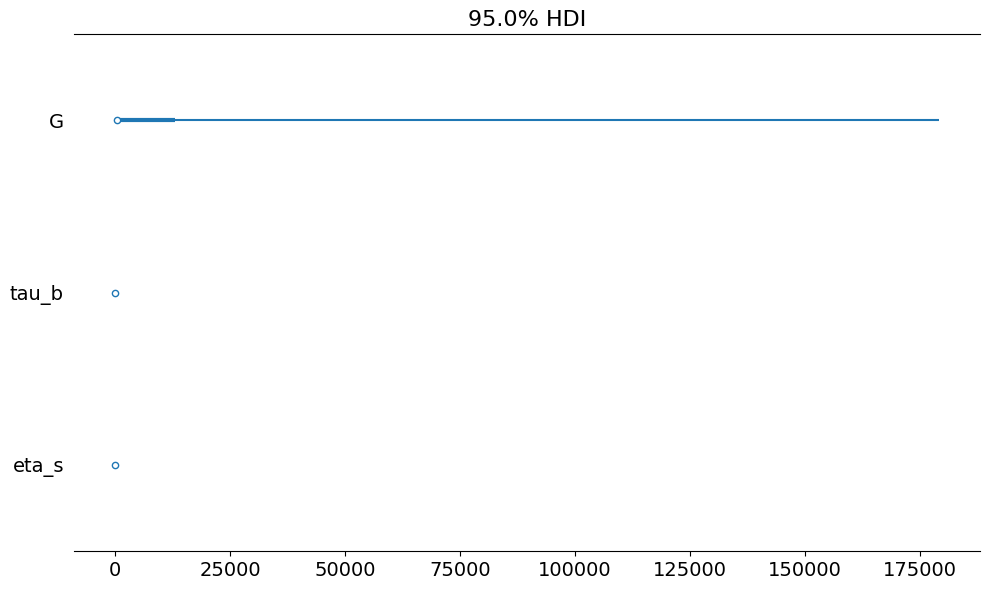

In [12]:
# ArviZ forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    hdi_prob=0.95,
    figsize=(10, 6)
)
plt.tight_layout()
plt.show()
plt.close('all')

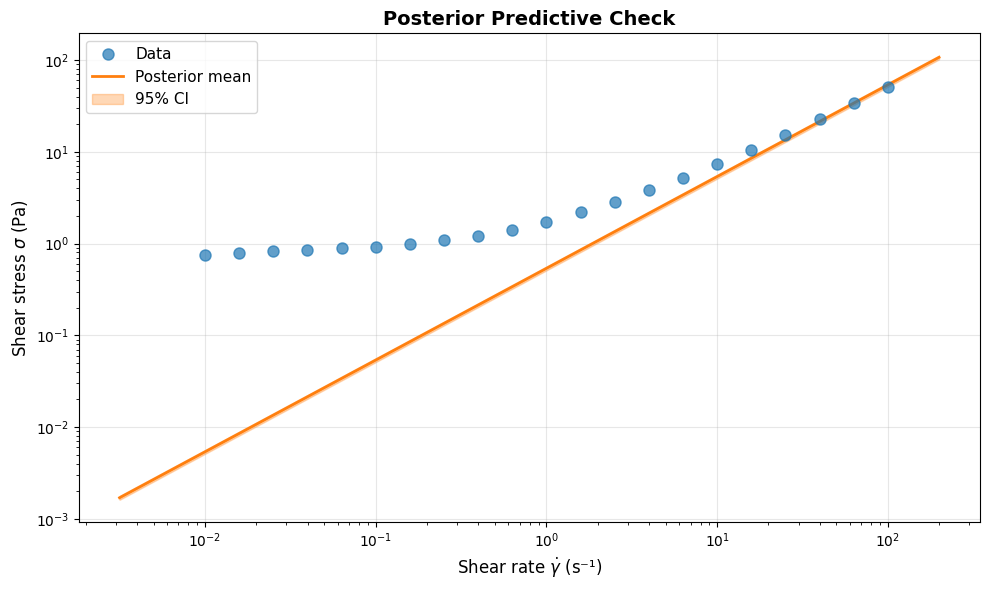

In [13]:
# Posterior predictive check
gamma_dot_pred = np.logspace(np.log10(gamma_dot.min())-0.5, np.log10(gamma_dot.max())+0.3, 200)
n_draws = min(200, NUM_SAMPLES)
posterior_preds = []

# Sample from posterior
for i in range(n_draws):
    params_i = jnp.array([bayesian_result.posterior_samples[name][i] for name in param_names])
    pred_i = model.model_function(jnp.array(gamma_dot_pred), params_i, test_mode="flow_curve")
    posterior_preds.append(np.array(pred_i))

posterior_preds = np.array(posterior_preds)
pred_mean = np.mean(posterior_preds, axis=0)
pred_lower = np.percentile(posterior_preds, 2.5, axis=0)
pred_upper = np.percentile(posterior_preds, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, 'o', label='Data', markersize=8, alpha=0.7, zorder=3)
ax.loglog(gamma_dot_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
ax.fill_between(gamma_dot_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=12)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
ax.set_title('Posterior Predictive Check', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         1.002           346  [1.273, 2.298e+05]
          tau_b        0.7334      0.000535  [1.304e-06, 0.3043]
          eta_s     1.162e-12        0.2411  [0.008749, 0.5127]


## 6. Physical Interpretation

### Constant Breakage = UCM Model

For constant breakage rate $\beta = 1/\tau_b$, the TNT model reduces to the Upper Convected Maxwell (UCM) model:

$$
\sigma = G \tau_b \dot{\gamma} + \eta_s \dot{\gamma} = (\eta_{network} + \eta_s) \dot{\gamma}
$$

This is a **Newtonian response** — no shear thinning. The flow curve is linear in log-log space with slope 1.

### Physical Parameters

- **Network modulus G**: Stiffness of the transient network
- **Breakage time τ_b**: Average lifetime of crosslinks
- **Network viscosity η_network = G·τ_b**: Polymer contribution
- **Solvent viscosity η_s**: Background solvent contribution

### Weissenberg Number

The Weissenberg number $Wi = \dot{\gamma} \tau_b$ compares the flow timescale to the relaxation timescale:
- $Wi \ll 1$: Linear viscoelastic regime (network relaxes faster than deformation)
- $Wi \sim 1$: Transition regime
- $Wi \gg 1$: Nonlinear regime (deformation faster than relaxation)

For constant breakage, there is no shear thinning even at high Wi.

### Normal Stress Differences

The TNT model predicts normal stress differences:

$$
N_1 = 2G(\tau_b \dot{\gamma})^2
$$

This is a signature of viscoelasticity — normal stresses arise from polymer stretching.

### Bell Breakage for Shear Thinning

To capture shear thinning, use **Bell breakage**: $\beta = (1/\tau_b) \exp(\nu \tau / G)$

This introduces stress-dependent bond breaking, leading to a decrease in viscosity at high shear rates.

## 7. Save Results

In [15]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "flow_curve", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/flow_curve/
  nlsq_params_flow_curve.json: 3 parameters
  posterior_flow_curve.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **TNT constant breakage = UCM**: Linear flow curve, no shear thinning
2. **Three parameters**: G (modulus), τ_b (breakage time), η_s (solvent viscosity)
3. **Weissenberg number**: Wi = γ̇·τ_b characterizes flow regime
4. **Normal stresses**: N₁ = 2G(τ_b·γ̇)² from polymer stretching
5. **Bayesian inference**: Quantifies parameter uncertainty with NUTS
6. **Bell variant**: Adds stress-dependent breakage for shear thinning

## Next Steps

- **Notebook 02**: Startup shear with stress overshoot
- **Notebook 03**: Stress relaxation for single-exponential decay
- **Notebook 05**: SAOS for frequency-dependent moduli
- **Notebook 06**: LAOS for nonlinear response